# Objectness Classification Models Analysis

In [1]:
import os
import sys
import git
import matplotlib.pyplot as plt
import torch

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

## Loading data

In [4]:
sys.path.append(f"{git_root}/objectness_classification/")
from seed import set_seed
sys.path.append(f"{git_root}/objectness_classification/datasets")
from datamodule import ObjnessClsDataModule

home = os.path.expanduser("~")
dataset_dir = os.path.join(home, "Documents/datasets")

set_seed()
iter_counter = 0

egohos_dataset = ObjnessClsDataModule(
    dataset_dir=dataset_dir,
    dataset_mode='egohos',
    batch_size=1,
    with_transform=True,
    with_info=True,
)
egohos_dataset.setup()

egohos_train_dataloader = iter(egohos_dataset.train_dataloader())

iter counter: 1
frames shape: torch.Size([1, 3, 224, 224])
label shape: torch.Size([1, 2, 224, 224])
converted frames shape: torch.Size([224, 224, 3])
file name: ('epic_P08_10_frame_0000007651',)


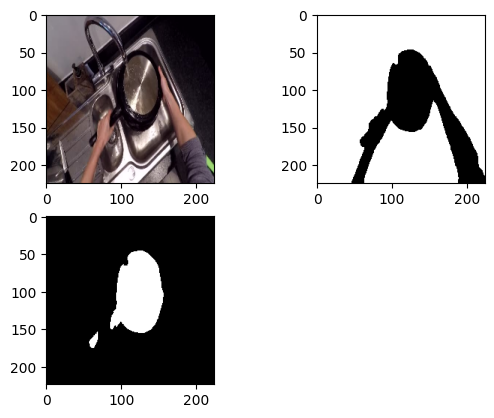

In [5]:
egohos_frames, egohos_labels, egohos_file = next(egohos_train_dataloader)
iter_counter += 1
# convert [batch, channel, height, width]
# to [batch, height, width, channel] for showing
egohos_img = egohos_frames.permute(0,2,3,1)[0]
egohos_mask = egohos_labels[0]
cls_num, _, _ = egohos_mask.shape

print(
    f"iter counter: {iter_counter}",
    f"frames shape: {egohos_frames.shape}",
    f"label shape: {egohos_labels.shape}",
    f"converted frames shape: {egohos_img.shape}",
    f"file name: {egohos_file}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(egohos_img)

for cls in range(cls_num):
    fig.add_subplot(2, 2, 2+cls)
    plt.imshow(egohos_mask[cls])
    plt.gray()

plt.show()

plt.clf()
plt.close()

## Semantic segmenting

In [2]:
from unet import System

system = System()
model = system.model

model_path = os.path.join(git_root, "objectness_classification/logs/unet.ckpt")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
model.eval()

Unet(
  (unet): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tr

(1, 224, 224)
model input shape: torch.Size([1, 3, 224, 224])
model output shape: (1, 2, 224, 224)
[[0.48786578 0.48650923 0.4860448  ... 0.48537636 0.48793122 0.5080789 ]
 [0.48103017 0.48345426 0.4730269  ... 0.46943945 0.48593915 0.4956678 ]
 [0.46770558 0.44873762 0.4294349  ... 0.441314   0.4422492  0.48216742]
 ...
 [0.470181   0.46060166 0.432332   ... 0.41765308 0.41910282 0.44621614]
 [0.48545736 0.48443645 0.46027997 ... 0.4317217  0.42791736 0.4605587 ]
 [0.50038344 0.48687002 0.47586235 ... 0.44098338 0.45041862 0.45843115]] [[0.4881488  0.53331447 0.5398696  ... 0.52741575 0.5339579  0.5177238 ]
 [0.50687796 0.53631526 0.5557857  ... 0.52348506 0.527366   0.5119273 ]
 [0.5011325  0.52806354 0.5738822  ... 0.5410976  0.5660442  0.53827167]
 ...
 [0.48983726 0.51667666 0.52222383 ... 0.48394686 0.5436698  0.5282548 ]
 [0.5053126  0.5159727  0.5159686  ... 0.49065983 0.5243789  0.525977  ]
 [0.47987926 0.4967636  0.509614   ... 0.49812907 0.5081175  0.5205046 ]]
[[1 1 1 ... 1

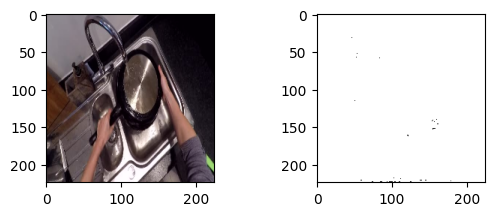

In [9]:
input = egohos_frames.float()
output = model(input)
output = output.detach().numpy()

print(
    f"model input shape: {input.shape}",
    f"model output shape: {output.shape}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(egohos_img)

print(output[0][0], output[0][1])
print(output.argmax(axis=1)[0])

fig.add_subplot(2, 2, 2)
plt.imshow(output.argmax(axis=1)[0])
plt.gray()

# for cls in range(cls_num):
#     fig.add_subplot(2, 2, 2+cls)
#     plt.imshow(output[0][cls])
#     plt.gray()

plt.show()

plt.clf()
plt.close()

## Heatmap of encoder

input shape: torch.Size([1, 3, 224, 224])
non-trained resnet output shape: torch.Size([1, 1000])
resnet output shape: torch.Size([1, 1000])
Argmax of output: 577 577


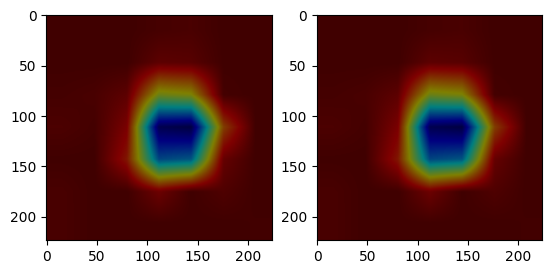

In [10]:
import numpy as np
import cv2
import torchvision.models as models
from torchcam.methods import GradCAM

# find argmax of non-trained model prediction
nt_resnet = models.resnet101(weights='DEFAULT')
nt_resnet.eval()

nt_cam_extractor = GradCAM(nt_resnet)

nt_out = nt_resnet(input)
class_idx = nt_out.squeeze(0).argmax().item()

# apply trained weight to model
param = torch.load(model_path, map_location=torch.device('cpu'))["state_dict"]
new_param = {}
for k in param.keys():
    if "model.unet.encoder" in k:
        new_param[k[19:]] = param[k]

resnet = models.resnet101(weights='DEFAULT')
resnet.load_state_dict(new_param, strict=False)
resnet.eval()

cam_extractor = GradCAM(resnet)

out = resnet(input)
class_idx2 = nt_out.squeeze(0).argmax().item()

print(
    f"input shape: {input.shape}",
    f"non-trained resnet output shape: {nt_out.shape}",
    f"resnet output shape: {out.shape}",
    f"Argmax of output: {class_idx} {class_idx2}",
    sep="\n",
)

# function to create heatmap from given CAMs
def create_heatmap(cams):
    for cam in cams:
        map = cam.squeeze(0).numpy()

        map_min = np.min(map)
        map_max = np.max(map)
        map = (map - map_min)/(map_max - map_min)

        map = cv2.resize(map, (224,224))
        map = (map*255).astype(np.uint8)

        heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
        output = heatmap * 0.5 + egohos_img.detach().numpy() * 0.5

    return output

# show heatmaps of CAM
nt_heatmap = create_heatmap(nt_cam_extractor(class_idx, nt_out))
heatmap = create_heatmap(cam_extractor(class_idx2, out))

fig = plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(nt_heatmap.astype(np.uint8))

fig.add_subplot(1, 2, 2)
plt.imshow(heatmap.astype(np.uint8))

plt.show()

plt.clf()
plt.close()
